In [2]:
reset -fs

In [3]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

In [4]:
# Code provided via http://jmcauley.ucsd.edu/data/amazon/

def parse_gz(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def convert_to_DF(path):
    i = 0
    df = {}
    for d in parse_gz(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
# Load datas
health_products = convert_to_DF('reviews_Health_and_Personal_Care.json.gz')

In [6]:
print('Dataset size: {:,} words'.format(len(health_products)))

Dataset size: 2,982,326 words


In [7]:
health_products[:3]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ARMDSTEI0Z7YW,0077614992,dodo,"[0, 0]",This book was a requirement for a college clas...,5.0,great,1360886400,"02 15, 2013"
1,A3FYN0SZYWN74,0615208479,Marilyn Mitzel,"[0, 0]",This is a great gift for anyone who wants to h...,5.0,AMAZING HOW QUICKLY IT WORKS!,1228089600,"12 1, 2008"
2,A2J0WRZSAAHUAP,0615269990,icu-rn,"[0, 0]",Very helpful in learning about different disea...,5.0,Must have,1396742400,"04 6, 2014"


In [8]:
health_products["reviewTime"] = pd.to_datetime(health_products["reviewTime"])

In [9]:
health_products = health_products[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'helpful', 'reviewTime',
      'unixReviewTime']]

In [11]:
health_products.head(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,0077614992,great,This book was a requirement for a college clas...,5.0,ARMDSTEI0Z7YW,dodo,"[0, 0]",2013-02-15,1360886400
1,0615208479,AMAZING HOW QUICKLY IT WORKS!,This is a great gift for anyone who wants to h...,5.0,A3FYN0SZYWN74,Marilyn Mitzel,"[0, 0]",2008-12-01,1228089600
2,0615269990,Must have,Very helpful in learning about different disea...,5.0,A2J0WRZSAAHUAP,icu-rn,"[0, 0]",2014-04-06,1396742400


In [12]:
health_products.tail(3)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
2982323,B00LWTTO0A,Great way to take care on my skin at home.,Great way to take care on my skin at home.I us...,5.0,A1252ETWUJRKVC,Kim.L.,"[0, 0]",2014-07-18,1405641600
2982324,B00LWTTO0A,Good quality clay,"Good quality clay, saves me salon visits to tr...",5.0,A215W0EOUNL81C,Tina S.,"[0, 0]",2014-07-18,1405641600
2982325,B00LYPUPZK,One Star,Fake!,1.0,A2ZFFXGLJUHD76,Dan Bernstein,"[0, 0]",2014-07-21,1405900800


In [13]:
products = health_products['overall'].groupby(health_products['asin']).count()
print("Number of Unique Products in the Health and Personal Care Category = {}".format(products.count()))

Number of Unique Products in the Health and Personal Care Category = 252331


In [14]:
sorted_products = products.sort_values(ascending=False)

print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B001KXZ808 - has {} reviews.'.format(products.max()))

Top 20 Reviewed Products:

asin
B001KXZ808    11365
B0032TNPOE     9338
B0095PZHPE     6788
B00B5H5BGA     5739
B0000U1OCI     5550
B001ADL1SG     5124
B0010JLMO8     5003
B009VUZJTM     4301
B000KUHFGM     3862
B00A8SLH8I     3767
B000GIPJY8     3567
B001U0OFCS     3237
B0026HDURA     3182
B004L6NTHU     3180
B004D9P1A8     3103
B0049LUI9O     3071
B00HK61L3C     3066
B003WR3QSG     2417
B000NL0T1G     2369
B00CJAV0US     2357
Name: overall, dtype: int64

Most Reviewed Product, B001KXZ808 - has 11365 reviews.


In [15]:
health_products['reviewText'][:11]

0     This book was a requirement for a college clas...
1     This is a great gift for anyone who wants to h...
2     Very helpful in learning about different disea...
3     Occam's Razor is an unbelievably intuitive and...
4     I met the guys from Nerdcore at a medical conf...
5     Love this little book, Has allot of great reci...
6     This is a great simple book for blender bottle...
7     You have to be a breast cancer survivor, which...
8     Aphrodite Reborn tells the dramatic and courag...
9     What an inspiring and visually stunning book M...
10    The new book is FABULOUS! I thought Reconstruc...
Name: reviewText, dtype: object

In [16]:
reviews = health_products['reviewText']

In [17]:
reviews.count()

2982326

In [18]:
stops = stopwords.words('english')

In [19]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [20]:
reviews = reviews.apply(lambda x: tokenize(x))

In [21]:
reviews[:11]

0     [This, book, wa, a, requirement, for, a, colle...
1     [This, is, a, great, gift, for, anyone, who, w...
2     [Very, helpful, in, learning, about, different...
3     [Occam, s, Razor, is, an, unbelievably, intuit...
4     [I, met, the, guy, from, Nerdcore, at, a, medi...
5     [Love, this, little, book, , Has, allot, of, g...
6     [This, is, a, great, simple, book, for, blende...
7     [You, have, to, be, a, breast, cancer, survivo...
8     [Aphrodite, Reborn, tell, the, dramatic, and, ...
9     [What, an, inspiring, and, visually, stunning,...
10    [The, new, book, is, FABULOUS, , I, thought, R...
Name: reviewText, dtype: object

In [22]:
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(health_products.reviewText))

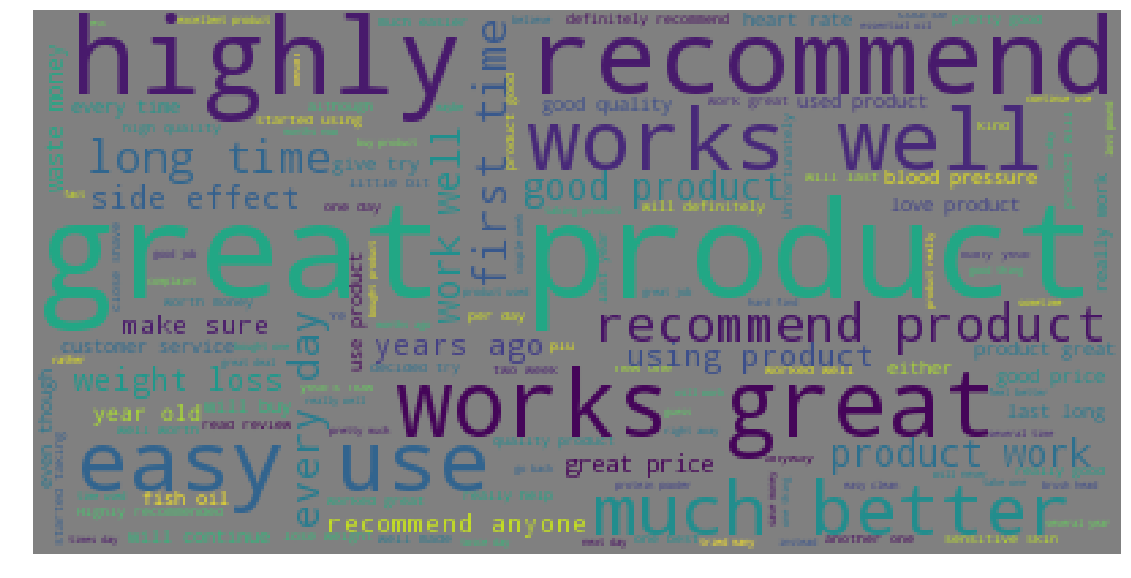

In [23]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud)

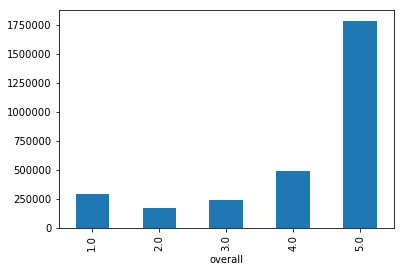

In [24]:
health_products.groupby(health_products.overall).size().plot(kind='bar')

In [26]:
review_text = health_products["reviewText"]

# Use tf-idf features
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(review_text)

# Use tf features
tf_vectorizer = CountVectorizer(stop_words=stops)
tf = tf_vectorizer.fit_transform(review_text)

In [27]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Number of total features: {}".format(len(tfidf_feature_names)))

Number of total features: 452715


In [28]:
# Initialize NMF
nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5)

# Initialize Ida
lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [29]:
num_top_words = 15

def retrieve_top_words(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]), end='\n\n')
    print()

In [30]:
nmf_tf = nmf.fit(tf)

In [31]:
nmf_ = nmf_tf.transform(tf)
Counter([np.argmax(i) for i in nmf_])

Counter({0: 534918,
         1: 19921,
         2: 421204,
         3: 189705,
         4: 18988,
         5: 141207,
         6: 440180,
         7: 388508,
         8: 421991,
         9: 405704})

In [32]:
retrieve_top_words(nmf_tf, tfidf_feature_names, num_top_words)

Topic #0:
get day time take first also work taking much back even weight two days really

Topic #1:
omega oil fish gel per cap mgs 1000 free dha price mg epa followed enteric

Topic #2:
product products recommend good using used amazon skin results company bottle works received found tried

Topic #3:
one never going reviews fill bought two another new buy old amazon years best got

Topic #4:
magnesium per price 100 mgs citrate chelated amazon oxide using mg foods capsules gel ingredients

Topic #5:
razor shave shaving shaver blades blade hair get face skin used close electric using razors

Topic #6:
use easy used using clean well water also time hair works need get little cleaning

Topic #7:
great works price love well really easy buy good recommend work bought quality little nice

Topic #8:
like good really taste feel smell little protein much also well better water think nice

Topic #9:
would 34 recommend buy could well thought work anyone back bought even batteries size price




In [33]:
nmf_tfidf = nmf.fit(tfidf)

In [34]:
nmf_W = nmf_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in nmf_W])

Counter({0: 830627,
         1: 248962,
         2: 306270,
         3: 257073,
         4: 164006,
         5: 467381,
         6: 305201,
         7: 227280,
         8: 93100,
         9: 82426})

In [35]:
retrieve_top_words(nmf_tfidf, tfidf_feature_names, num_top_words)

Topic #0:
one would time get work bought like used buy batteries back much got long little

Topic #1:
great price buy value deal quality fast taste protein shipping job thanks smells tastes stuff

Topic #2:
product recommend would highly anyone excellent using used happy results definitely purchase products order years

Topic #3:
good price quality taste buy value pretty protein job like really far deal tastes nice

Topic #4:
razor shave shaving blades shaver blade close skin hair razors face electric smooth gillette using

Topic #5:
take taking day feel really like energy taste pills weight help started weeks difference using

Topic #6:
use love easy clean smell also every makes water nice oil skin scent like keep

Topic #7:
works well really work stuff fine better advertised worth made like worked perfectly seems expected

Topic #8:
34 size like said says say little smell natural scent know made however small actually

Topic #9:
scale weight accurate easy read step loss scales bathro